# JAX CNN

En este notebook practicamos un poco con la programación diferenciable de JAX construyendo ejemplos adversariales.

En primer lugar definimos y entrenamos una red convolucional sencilla. Está copiada de la que hemos hecho en Keras para MNIST, pero quitamos el dropout porque necesita meter los `rng` y complica un poco el código.

In [1]:
import jax
import jax.numpy as jnp

from flax import linen as nn

class SimpleCNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME', name='conv1')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME', name='conv2')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        x = x.reshape((x.shape[0], -1))  # Flatten
        #x = nn.Dropout(rate=0.5)(x, deterministic=False)
        x = nn.Dense(features=10, name='dense')(x)
        x = nn.softmax(x)
        return x

Los ejemplos los sacamos de Keras, donde tenemos clara la normalización.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import keras
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

cl = y_train
ct = y_test

num_classes=10
# convert class labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(60000, 28, 28) (60000,)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Hay que inicializar la red con datos `dummy` para que se organice internamente.

In [4]:
model = SimpleCNN()

In [5]:
variables = model.init(jax.random.key(0), jnp.ones((1,28,28,1)))

2024-04-12 13:18:30.517209: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Puede salir algún *warning*, pero si tenemos la GPU bien configurada lo importante es que en la siguiente celda salga `cuda`:

In [6]:
jax.devices()

[cuda(id=0)]

Verificamos que las dimensiones de salida son consistentes con las entradas:

In [7]:
output = model.apply(variables, jnp.ones((7,28,28,1)))

In [8]:
output.shape

(7, 10)

Por sencillez optimizamos el error cuadrático (aunque sería mejor la crossentropy).

In [9]:
def loss(variables,x,y):
    return jnp.mean((model.apply(variables,x) - y)**2)

In [10]:
loss(variables, x_train[:10], y_train[:10])

Array(0.09125638, dtype=float32)

In [11]:
grad_fn = jax.jit(jax.value_and_grad(loss))

El módulo `flax` para hacer redes con `jax` usa unas estructuras especiales para guardar los parámetros de un modelo. Necesitamos la siguiente función auxiliar para acctualizarlos.

In [12]:
@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

Definimos nuestro propio *stochastic gradient descent* (SGD):

In [13]:
lr = 1e-1
nbatch = 250
w = model.init(jax.random.key(0), jnp.ones((1,28,28,1)))

for epoch in range(30):
    r = np.random.permutation(len(x_train))
    acloss = 0
    for k in range(len(x_train)//nbatch):
        select = r[k*nbatch:(k+1)*nbatch]
        l, g = grad_fn(w, x_train[select], y_train[select])
        acloss += l
        w = update_params(w, lr, g)
    print(epoch, acloss)

0 18.059954
1 7.5228786
2 4.4843373
3 3.6271744
4 3.1790102
5 2.885961
6 2.6565568
7 2.4729555
8 2.316346
9 2.1849875
10 2.0683057
11 1.9638747
12 1.8718023
13 1.7903966
14 1.7117388
15 1.6406102
16 1.5757151
17 1.522045
18 1.4676843
19 1.416237
20 1.3724797
21 1.3279872
22 1.2942588
23 1.2567873
24 1.221005
25 1.1946336
26 1.1639574
27 1.1382073
28 1.1129299
29 1.0893986


No va mal, pero como suele suceder, el método ADAM es mucho más rápido:

In [14]:
import optax

lr = 1e-4
nbatch = 250
nepochs= 30
w = model.init(jax.random.key(0), jnp.ones((1,28,28,1)))

tx = optax.adam(learning_rate=lr)
opt_state = tx.init(w)

for epoch in range(nepochs):
    r = np.random.permutation(len(x_train))
    acloss = 0
    for k in range(len(x_train)//nbatch):
        select = r[k*nbatch:(k+1)*nbatch]
        l, g = grad_fn(w, x_train[select], y_train[select])
        acloss += l
        updates, opt_state = tx.update(g, opt_state)
        w = optax.apply_updates(w, updates)

    print(epoch, acloss)

0 9.966686
1 3.049809
2 2.1402822
3 1.6877234
4 1.404421
5 1.2089978
6 1.070253
7 0.97209233
8 0.8937618
9 0.8283967
10 0.7725745
11 0.723294
12 0.68576735
13 0.6487561
14 0.62380725
15 0.593022
16 0.5690764
17 0.5474778
18 0.5299766
19 0.5050686
20 0.48944545
21 0.47330064
22 0.45457056
23 0.4473565
24 0.4323661
25 0.41969758
26 0.4044593
27 0.39430046
28 0.37984157
29 0.3679229


Verificamos que realmente hemos aprendido algo cercano al 99% (como la red que hicimos con keras):

In [15]:
def success_rate(model, parameters, X, C, nbatch):
    r = []
    for k in range(len(X)//nbatch):
        xx = X[k*nbatch:(k+1)*nbatch]
        yy = C[k*nbatch:(k+1)*nbatch]
        p = jnp.argmax(model.apply(parameters,xx),axis=1) == yy
        r.append(jnp.mean(p))
    return jnp.array(r).mean()

In [16]:
success_rate(model, w, x_train, cl, 100)

Array(0.99221665, dtype=float32)

In [17]:
success_rate(model, w, x_test, ct, 100)

Array(0.9876, dtype=float32)

Le falta una fracción para llegar al 99% de test, que tal vez puede atribuirse a que no hemos incluido el *dropout*.

Ahora elegimos una "víctima", que vamos a modificar levemente para engañar a la red.

In [18]:
import matplotlib.pyplot as plt

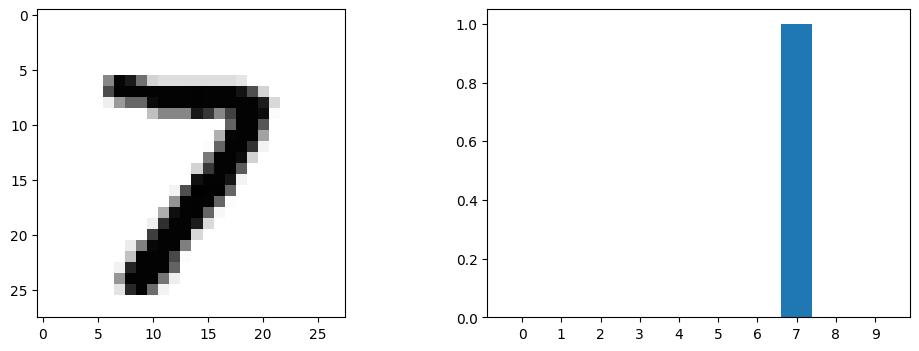

In [19]:
k = 4000
B = x_train[k]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.imshow(1-B,'gray',vmin=0,vmax=1)
ax2.bar(np.arange(10), model.apply(w, jnp.array([B]))[0])
ax2.set_xticks(np.arange(10));

El criterio de coste es simplemente acercar las salidas a una determinada respuesta distinta de la correcta. El parámetro es la perturbación de la entrada, los pesos de la red ahora son constantes. No hace falta tener en cuenta nada más porque solo nos interesan los signos del gradiente. Queremos la dirección en la que debemos aplicar una pequeña perturbación.

In [20]:
@jax.jit
def adversarial(delta):
    r = model.apply(w, jnp.array([B+delta]))
    y = jnp.eye(10)[3]
    loss = jnp.sum((r-y)**2)
    return loss

In [21]:
D = jnp.zeros((28,28,1))
adversarial(D)

Array(1.9996634, dtype=float32)

In [22]:
ad_grad_fn = jax.jit(jax.value_and_grad(adversarial))

In [23]:
eps = 0.01

D = jnp.zeros((28,28,1))

for k in range(10):
    l, g = ad_grad_fn(D)
    print(k, l)
    D += -eps*jnp.sign(g)

0 1.9996634
1 1.9991536
2 1.9974978
3 1.9921381
4 1.9742751
5 1.9111421
6 1.6923052
7 1.1476854
8 0.42526025
9 0.07428199


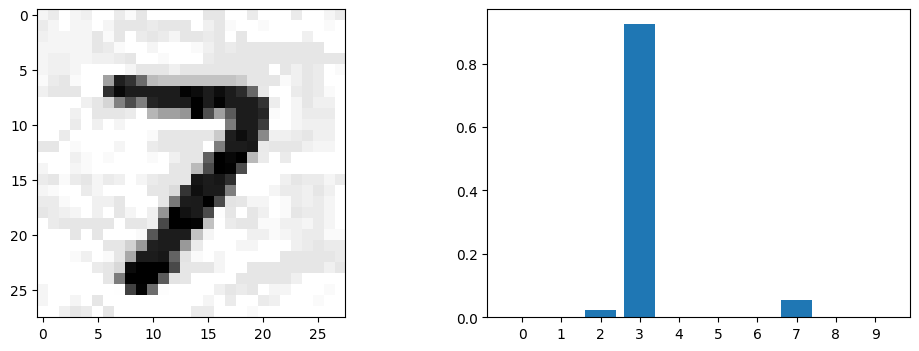

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.imshow(1-(B+D),'gray',vmin=0,vmax=1)
ax2.bar(np.arange(10), model.apply(w, jnp.array([B+D]))[0])
ax2.set_xticks(np.arange(10));